In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.cloud import bigquery
client = bigquery.Client.from_service_account_json(
        'GDELT2-c60e8f0ed67d.json')

In [3]:
event_codes = pd.read_csv('CAMEO.eventcodes.csv', sep='\t', dtype='str')
event_codes.index = event_codes['CAMEOEVENTCODE']
event_codes.drop(['CAMEOEVENTCODE'], inplace=True, axis=1)

In [4]:
cameo_county_codes = pd.read_csv('CAMEO.country.csv', sep='\t', dtype='str')

In [7]:
fpis_region_codes = pd.read_csv('FIPS.region.csv', dtype='str')
fpis_country_codes = pd.read_csv('FIPS.country.csv', dtype='str', sep='\t', names=['CODE', 'LABEL'])

In [6]:
def year_month_to_date(ym):
    return pd.Timestamp(year=int(ym / 100), month=int(ym % 100), day=1)

In [7]:
def get_result_dataframe(query, index_col_name=None, datetime_cols=None):
    query_job = client.query(query)
    rows = []
    for row in query_job: 
        rows.append(pd.Series(dict(row.items())))
    df = pd.DataFrame(rows)
    if datetime_cols is not None:
        for datetime_col in datetime_cols:
            df[datetime_col] = pd.to_datetime(df[datetime_col], format='%Y%m%d', errors='ignore')
    if index_col_name is not None:
        df.index = df[index_col_name]
        df.drop([index_col_name], inplace=True, axis=1)
    return(df)

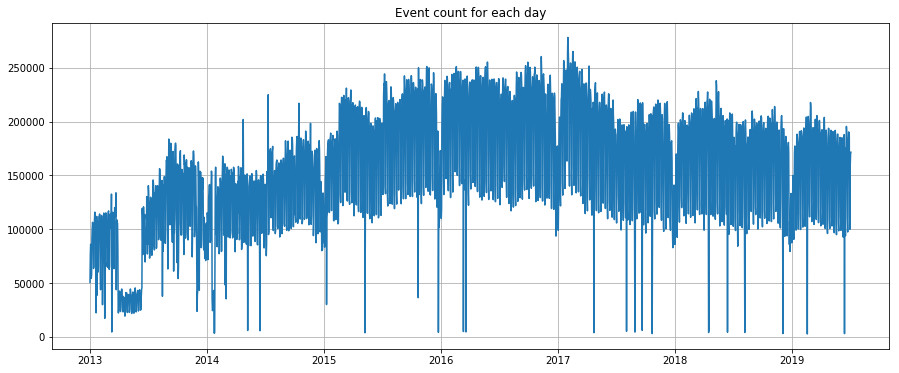

In [4]:
query = """
SELECT SQLDATE AS Date, count(*) AS EventCount
FROM `gdelt-bq.full.events`
WHERE SQLDATE >= 20130101
GROUP BY SQLDATE"""
df = get_result_dataframe(query, index_col_name='Date', datetime_cols=['Date'])
plt.figure(figsize(15,6))
plt.plot(df.sort_index()['EventCount'])
plt.grid()
plt.title('Event count for each day')
plt.show()

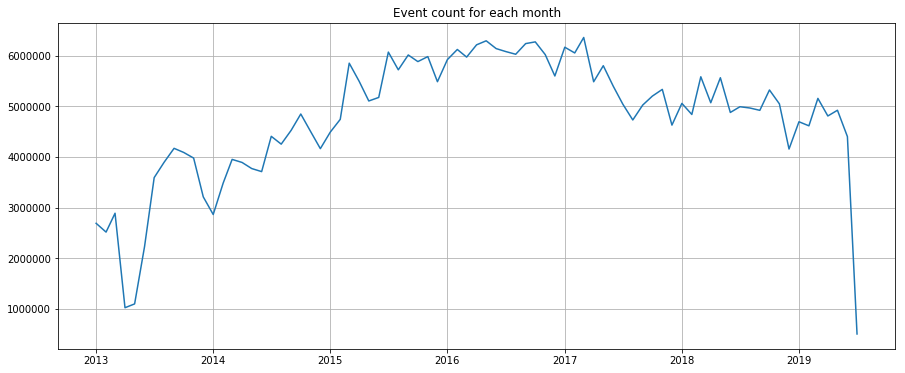

In [19]:
query = """
SELECT MonthYear AS Date, count(*) AS EventCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
GROUP BY MonthYear"""
df = get_result_dataframe(query, index_col_name='Date', datetime_cols=['Date'])
df.index = pd.Series(df.index).apply(lambda date: pd.Timestamp(
    year=int(date / 100), 
    month=int(date % 100),
    day=1))
plt.figure(figsize(15,6))
plt.plot(df.sort_index()['EventCount'])
plt.grid()
plt.title('Event count for each month')
plt.show()

In [229]:
cameo_country_id = 'POL'
fips_country_code = 'PL'

query = """
SELECT EventBaseCode as EventType, MonthYear AS Date, count(*) AS EventCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND (Actor1CountryCode  = "{}" 
OR Actor1Geo_CountryCode = "{}"
OR Actor2CountryCode = "{}"
OR Actor2Geo_CountryCode = "{}"
OR ActionGeo_CountryCode = "{}")
GROUP BY MonthYear, EventBaseCode""".format(
    cameo_country_id,
    cameo_country_id,
    fips_country_code,
    fips_country_code,
    fips_country_code)
df = get_result_dataframe(query)

In [230]:
df = df.sort_values('Date')
df['Date'] = df['Date'].apply(lambda date: pd.Timestamp(
    year=int(date / 100), 
    month=int(date % 100),
    day=1))
df['EventType'] = df['EventType'].apply(lambda type_id: type_id[:2])

In [231]:
plt.figure(figsize(18,10))
for event_type in sorted(df['EventType'].unique()):
    try:
        df_type = df[df['EventType'] == event_type].groupby('Date').sum()
        plt.plot(df_type['EventCount'], label=event_codes.loc[event_type]['EVENTDESCRIPTION'])
    except KeyError as key_error:
        pass
plt.grid()
plt.legend()
plt.savefig('pol-a1.jpg')
plt.close()

In [76]:
fips_country_code = "CH"
query = """
SELECT "a1_a2_el" AS index, count(*) AS count 
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode = "{0}"
AND Actor2Geo_CountryCode = "{0}"
AND ActionGeo_CountryCode = "{0}"
UNION ALL
SELECT "a1_a2" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode = "{0}"
AND Actor2Geo_CountryCode = "{0}"
AND NOT ActionGeo_CountryCode = "{0}"
UNION ALL
SELECT "a1_el" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode = "{0}"
AND NOT Actor2Geo_CountryCode = "{0}"
AND ActionGeo_CountryCode = "{0}"
UNION ALL
SELECT "a2_el" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND NOT Actor1Geo_CountryCode = "{0}"
AND Actor2Geo_CountryCode = "{0}"
AND ActionGeo_CountryCode = "{0}"
UNION ALL
SELECT "a1" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode = "{0}"
AND NOT Actor2Geo_CountryCode = "{0}"
AND NOT ActionGeo_CountryCode = "{0}"
UNION ALL
SELECT "a2" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND NOT Actor1Geo_CountryCode = "{0}"
AND Actor2Geo_CountryCode = "{0}"
AND NOT ActionGeo_CountryCode = "{0}"
UNION ALL
SELECT "el" AS index, count(*) AS count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND NOT Actor1Geo_CountryCode = "{0}"
AND NOT Actor2Geo_CountryCode = "{0}"
AND ActionGeo_CountryCode = "{0}"
""".format(fips_country_code)
df = get_result_dataframe(query, index_col_name='index')
df['count'] = df['count'].astype('float32')

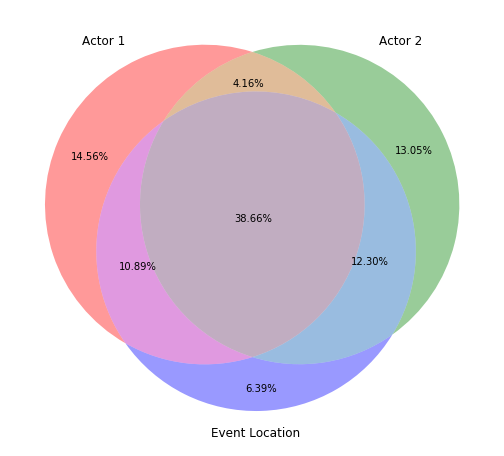

In [77]:
from matplotlib_venn import venn3
index = np.array(['a1', 'a2', 'a1_a2', 'el', 'a1_el', 'a2_el', 'a1_a2_el']) 
df = df.reindex(index)
labels = ['Actor 1', 'Actor 2', 'Event Location']
total = sum(df['count'])
plt.figure(figsize(10,8))
formatter = lambda x: '%.2f'%(x/total * 100.) + '%'
v=venn3(subsets = df['count'], set_labels = labels, subset_label_formatter=formatter)
plt.show()

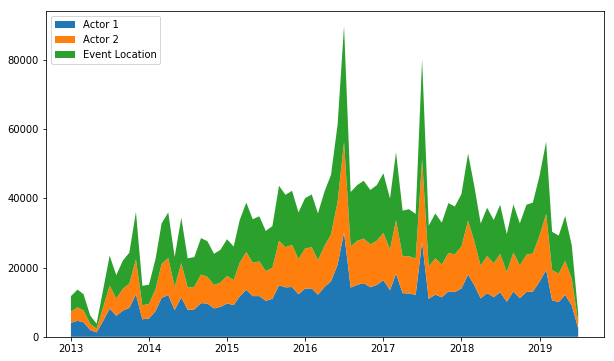

In [56]:
query_a1 = """
SELECT MonthYear, count(*) as Actor1PlaceCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode = "PL"
GROUP BY MonthYear
ORDER BY MonthYear"""
query_a2 = """
SELECT MonthYear, count(*) as Actor2PlaceCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor2Geo_CountryCode = "PL"
GROUP BY MonthYear
ORDER BY MonthYear"""
query_e = """
SELECT MonthYear, count(*) as EventPlaceCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND ActionGeo_CountryCode  = "PL"
GROUP BY MonthYear
ORDER BY MonthYear"""
df_a1 = get_result_dataframe(query_a1, index_col_name='MonthYear')
df_a2 = get_result_dataframe(query_a2, index_col_name='MonthYear')
df_e = get_result_dataframe(query_e, index_col_name='MonthYear')
df = pd.concat([df_a1, df_a2, df_e], axis=1)
df.index = pd.Series(df.index).apply(year_month_to_date)
fig, ax = plt.subplots(figsize=(10, 6))
ax.stackplot(df.index,
             df.Actor1PlaceCount,
             df.Actor2PlaceCount,
             df.EventPlaceCount,
             labels=['Actor 1', 'Actor 2', 'Event Location'])
ax.legend(loc='upper left')
plt.show()

In [144]:
cameo_country_id = 'POL'
fips_country_code = 'PL'

query = """
SELECT ActionGeo_Lat AS Lat, ActionGeo_Long AS Long, count(*) AS EventCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201801 AND MonthYear < 201901
AND ActionGeo_CountryCode = "{}" 
GROUP BY ActionGeo_Lat, ActionGeo_Long""".format(fips_country_code)
df = get_result_dataframe(query)

In [8]:
from mpl_toolkits.basemap import Basemap, cm

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


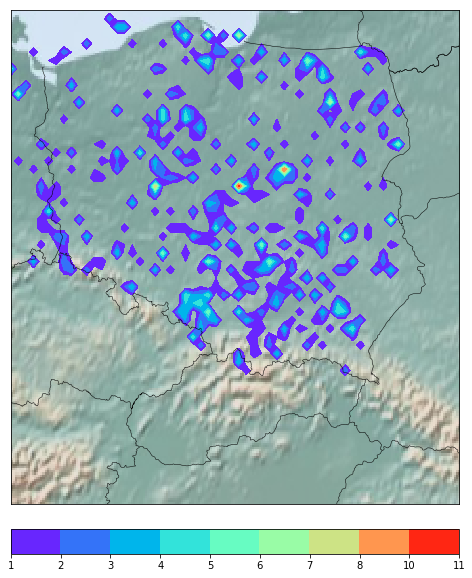

In [145]:
plt.figure(figsize(10, 10))
size = 60
width = df.Long.max() - df.Long.min()
height =  df.Lat.max() - df.Lat.min()
m = Basemap(llcrnrlon=df.Long.min(),
            llcrnrlat=df.Lat.min(),
            urcrnrlon=df.Long.max(),
            urcrnrlat=df.Lat.max(),
            resolution='h',
            projection='tmerc',
            lat_0=(df.Lat.min() + df.Lat.max()) / 2,
            lon_0=(df.Long.min() + df.Long.max()) / 2)
counts = np.zeros((size, size))
long_min = df.Long.min()
lat_min = df.Lat.min()
for row in df.iterrows():
    i = int(np.min(((size * (row[1].loc['Long'] - long_min) / width), size - 1)))
    j = int(np.min(((size * (row[1].loc['Lat'] - lat_min) / height), size - 1)))
    counts[j, i] += row[1].EventCount
counts = np.floor(np.log(counts))
counts = np.where(counts==np.NINF, 0.0, counts)
lons, lats = m.makegrid(size, size) 
x, y = m(lons, lats) 
clevs = sorted(np.unique(counts))[1:]
cs = m.contourf(x, y, counts, clevs, cmap='rainbow')
cbar = m.colorbar(cs,location='bottom',pad="5%")
m.drawcountries()
m.shadedrelief()
plt.show()

In [30]:
fips_country_code = 'SY'

query = """
SELECT Actor1CountryCode, Actor1Name, Actor1Type1Code, 
       Actor2CountryCode, Actor2Name, Actor2Type1Code, 
       ActionGeo_Lat AS Lat, ActionGeo_Long AS Long, count(*) AS EventCount
FROM `gdelt-bq.full.events`
WHERE MonthYear > 201901
AND ActionGeo_CountryCode = "{}" 
AND ActionGeo_Type IN UNNEST([3, 4])
AND QuadClass = 4
AND Actor1Type1Code IN UNNEST(["COP", "INS", "UAF", "MIL", "REB"])
AND Actor1CountryCode IS NOT NULL
AND Actor2CountryCode IS NOT NULL
GROUP BY Actor1CountryCode, Actor1Name, Actor1Type1Code, 
         Actor2CountryCode, Actor2Name, Actor2Type1Code,
         ActionGeo_Lat, ActionGeo_Long""".format(fips_country_code)
df = get_result_dataframe(query)

In [31]:
name_mapping = cameo_county_codes.groupby('CODE')['LABEL'].first()
df['Actor1'] = df['Actor1CountryCode'].map(name_mapping) + ' ' + df['Actor1Type1Code']

In [32]:
df[:5]

Actor1CountryCode Actor1Name Actor1Type1Code Actor2CountryCode Actor2Name  \
0               SYR      SYRIA             REB               SYR      SYRIA   
1               USA     ALASKA             MIL               IRQ       IRAQ   
2               SYR      SYRIA             MIL               TUR     TURKEY   
3               SYR      SYRIA             UAF               SYR      SYRIA   
4               ISR    ISRAELI             MIL               SYR     SYRIAN   

  Actor2Type1Code  EventCount      Lat     Long             Actor1  
0            None           1  35.3784  36.5381          Syria REB  
1            None           2  35.8478  35.8410  United States MIL  
2            None           1  36.2251  37.3266          Syria MIL  
3            None           1  36.5939  37.6876          Syria UAF  
4            None          12  33.5000  36.3000         Israel MIL

In [33]:
min_Long, max_Long = df.Long.quantile([0.01, 0.99])
min_Lat, max_Lat = df.Lat.quantile([0.01, 0.99])
df = df[(df.Long >= min_Long) & (df.Long <= max_Long) & (df.Lat >= min_Lat) & (df.Lat <= max_Lat)]

In [34]:
import os
from mapboxgl.utils import *
from mapboxgl.viz import *
token = "pk.eyJ1IjoidHltb2ZpaWNodW1hayIsImEiOiJjanh5bGJnamwwNmxpM3FxamJtb3Z6enV1In0.AXewkvl38OqO4bUHCsrDpA"

In [55]:
df_to_geojson(df, 
              filename='data/test.geojson',
              properties=['Actor1', 'EventCount'], 
              lat='Lat', 
              lon='Long', 
              precision=3)

{'feature_count': 447, 'filename': 'data/test.geojson', 'type': 'file'}

In [71]:
color_stops

[[1.0, 'rgb(252,141,89)'],
 [2.0, 'rgb(255,255,191)'],
 [4.0, 'rgb(153,213,148)']]

In [74]:
width = df.Long.max() - df.Long.min()
height =  df.Lat.max() - df.Lat.min()
center = ((df.Long.min() + df.Long.max()) / 2, (df.Lat.min() + df.Lat.max()) / 2)

measure = 'EventCount'
heatmap_color_stops = create_color_stops([0.01, 0.25, 0.5, 0.75, 1], colors='RdPu')
heatmap_radius_stops = [[0, 1], [14, 70]] # increase radius with zoom

color_breaks = np.unique([round(df[measure].quantile(q=x*0.1), 2) for x in range(2, 10)])
color_stops = create_color_stops(color_breaks, colors='Spectral')

heatmap_weight_stops = create_weight_stops(color_breaks)

viz = HeatmapViz('data/test.geojson', 
                  access_token=token,
                  weight_property='EventCount',
                  weight_stops=heatmap_weight_stops,
                  color_stops=heatmap_color_stops,
                  radius_stops=heatmap_radius_stops,
                  opacity=0.8,
                  center=center,
                  zoom=6,
                  below_layer='waterway-label')

viz.

In [26]:
import pandas as pd
import os
from mapboxgl.utils import *
from mapboxgl.viz import *

# Load data from sample csv
data_url = 'https://raw.githubusercontent.com/mapbox/mapboxgl-jupyter/master/examples/data/points.csv'
df = pd.read_csv(data_url)

# Must be a public token, starting with `pk`
token = os.getenv('MAPBOX_ACCESS_TOKEN')

# Create a geojson file export from a Pandas dataframe
df_to_geojson(df, filename='points.geojson',
              properties=['Avg Medicare Payments', 'Avg Covered Charges', 'date'],
              lat='lat', lon='lon', precision=3)

#Create a heatmap
heatmap_color_stops = create_color_stops([0.01,0.25,0.5,0.75,1], colors='RdPu')
heatmap_radius_stops = [[0,1], [15, 40]] #increase radius with zoom

color_breaks = [0,10,100,1000,10000]
color_stops = create_color_stops(color_breaks, colors='Spectral')

heatmap_weight_stops = create_weight_stops(color_breaks)

#Create a heatmap
viz = HeatmapViz('points.geojson',
                  access_token=token,
                  weight_property='Avg Medicare Payments',
                  weight_stops=heatmap_weight_stops,
                  color_stops=heatmap_color_stops,
                  radius_stops=heatmap_radius_stops,
                  opacity=0.9,
                  center=(-95, 40),
                  zoom=3,
                  below_layer='waterway-label')

viz.show()

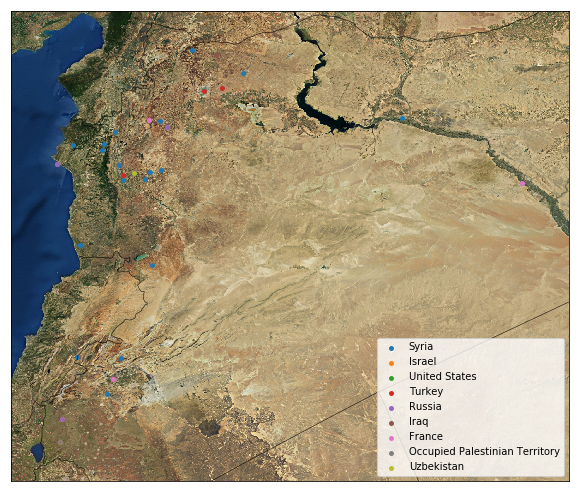

In [71]:
plt.figure(figsize(10, 10))
size = 60
width = df.Long.max() - df.Long.min()
height =  df.Lat.max() - df.Lat.min()
m = Basemap(llcrnrlon=df.Long.min() - 0.1 * width,
            llcrnrlat=df.Lat.min() - 0.1 * height,
            urcrnrlon=df.Long.max() + 0.1 * width,
            urcrnrlat=df.Lat.max() + 0.1 * height,
            resolution='h',
            projection='tmerc',
            lat_0=(df.Lat.min() + df.Lat.max()) / 2,
            lon_0=(df.Long.min() + df.Long.max()) / 2,
            epsg = 4269)

lons, lats = m.makegrid(size, size) 

for a1_country in df['Actor1CountryCode'].unique():
    a1_df = df[df['Actor1CountryCode'] == a1_country]
    x, y = m(list(a1_df['Long']), list(a1_df['Lat']))
    plt.scatter(x,y,15,marker='o', label=name_mapping.loc[a1_country])
m.drawcountries()
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= False)
plt.legend()
plt.show()

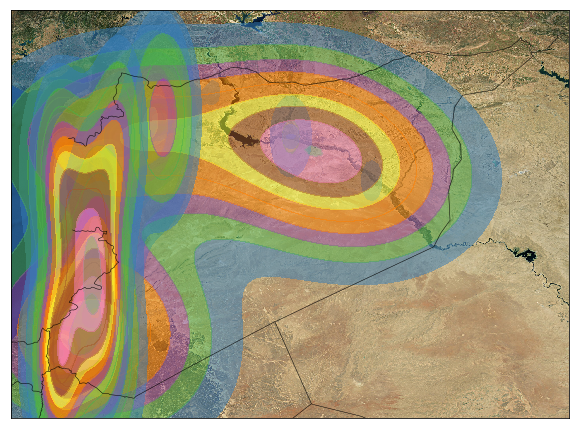

In [37]:
import seaborn as sns
fig = plt.figure(figsize(10, 10))
size = 60
width = df.Long.max() - df.Long.min()
height =  df.Lat.max() - df.Lat.min()
m = Basemap(llcrnrlon=df.Long.min() - 0.1 * width,
            llcrnrlat=df.Lat.min() - 0.1 * height,
            urcrnrlon=df.Long.max() + 0.1 * width,
            urcrnrlat=df.Lat.max() + 0.1 * height,
            resolution='h',
            projection='tmerc',
            lat_0=(df.Lat.min() + df.Lat.max()) / 2,
            lon_0=(df.Long.min() + df.Long.max()) / 2,
            epsg = 4269)

lons, lats = m.makegrid(size, size) 
name_mapping = cameo_county_codes.groupby('CODE')['LABEL'].first()
for a1_country in df['Actor2CountryCode'].unique():
    a1_df = df[df['Actor2CountryCode'] == a1_country]
    if a1_df.shape[0] < 5:
        continue
    x, y = m(list(a1_df['Long']), list(a1_df['Lat']))
    sns.kdeplot(x, y,  shade=True, shade_lowest=False, cut=2, cmap="Set1", label=name_mapping.loc[a1_country], alpha=0.5)
x, y = m(list(df['Long']), list(df['Lat']))    
m.drawcountries()
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 2000, verbose= False)
plt.legend()
plt.show()

In [40]:
df[:5]

Actor1CountryCode Actor1Name Actor1Type1Code Actor2CountryCode  \
0               SYR      SYRIA             MIL               SYR   
1               SYR      SYRIA             MIL               SYR   
2               ISR    ISRAELI             MIL               SYR   
3               USA   RICHMOND             COP               USA   
4               SYR      SYRIA             REB               SYR   

      Actor2Name Actor2Type1Code  EventCount      Lat     Long  \
0          SYRIA            None           1  35.9214  36.7394   
1          SYRIA            None           8  33.5000  36.3000   
2       DAMASCUS            None           5  33.5000  36.3000   
3  UNITED STATES            None           2  36.2028  37.1586   
4          SYRIA            None           1  36.2251  37.3266   

              Actor1  
0          Syria MIL  
1          Syria MIL  
2         Israel MIL  
3  United States COP  
4          Syria REB

In [47]:
import plotly_express as px
px.set_mapbox_access_token(open(".mapbox_token").read())
px.scatter_mapbox(df, lat='Lat', lon='Long', color='Actor1CountryCode')

In [9]:
country_code_to_name_mapping = cameo_county_codes.groupby('CODE').first()['LABEL']
fpis_country_code_to_name_mapping = fpis_country_codes.groupby('country_code').first()['country_name']

In [10]:
def rank_chart(values, labels, title):
    fig, ax1 = plt.subplots(figsize=(15, 7))
    pos = np.arange(len(values))
    rects = ax1.barh(pos, values,
              align='center',
              height=0.5,
              tick_label=labels)
    ax1.grid(axis='x', linestyle='--')
    ax2 = ax1.twinx()
    ax2.set_yticks(pos)
    ax2.set_ylim(ax1.get_ylim())
    max_width = max(values)
    for rect, label in zip(rects, values):
        width = rect.get_width()
        if rect.get_width() < max_width / 5:
            xloc = 5
            clr = 'black'
            align = 'left'
        else:
            xloc = -5
            clr = 'white'
            align = 'right'
        yloc = rect.get_y() + rect.get_height() / 2
        label = ax1.annotate(label, xy=(width, yloc), xytext=(xloc, 0),
                            textcoords="offset points",
                            ha=align, va='center',
                            color=clr, weight='bold', clip_on=True)
    ax1.set_title(title)
    plt.show()

In [11]:
def cat_month_year_stack_plot(df, cat_col_name, count_col_name, cat_to_name_mapping, th=5):
    df['MonthYear'] = df['MonthYear'].apply(year_month_to_date)
    df.sort_values('MonthYear', inplace=True)
    cat_codes = df[cat_col_name].unique()

    threshold = df[count_col_name].sum() / df[cat_col_name].nunique() * th
    sagnificant_codes = []
    sagnificant_categories = []
    other = pd.Series(np.zeros(df['MonthYear'].nunique()), index=df['MonthYear'].unique())
    for cat_code in cat_codes:
        category = df[df[cat_col_name] == cat_code][count_col_name]
        category.index = df[df[cat_col_name] == cat_code]['MonthYear']
        if category.sum() < threshold:
            other = other.add(category, fill_value=0)
        else:
            sagnificant_codes.append(cat_code)
            sagnificant_categories.append(category)

    sagnificant_codes.append('Other')
    sagnificant_categories.append(other)

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.stackplot(df['MonthYear'].unique(),
                 sagnificant_categories,
                 labels=pd.Series(sagnificant_codes).map(cat_to_name_mapping).fillna('Other'))
    ax.legend(loc='upper left')
    plt.show()

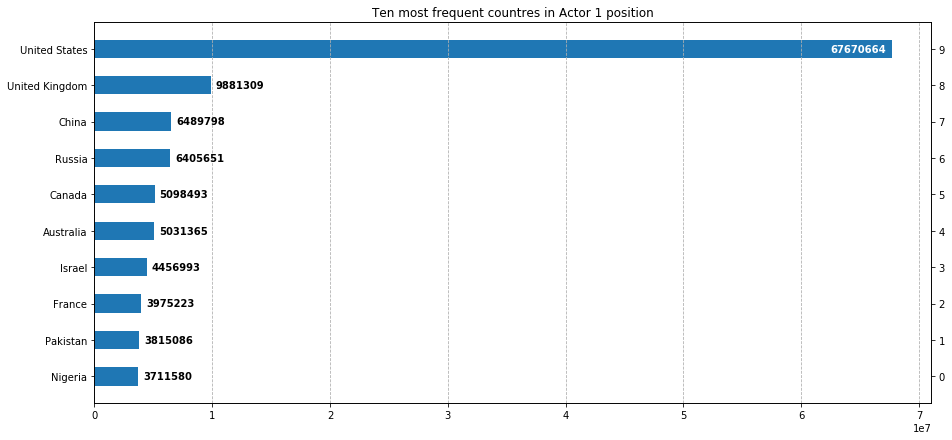

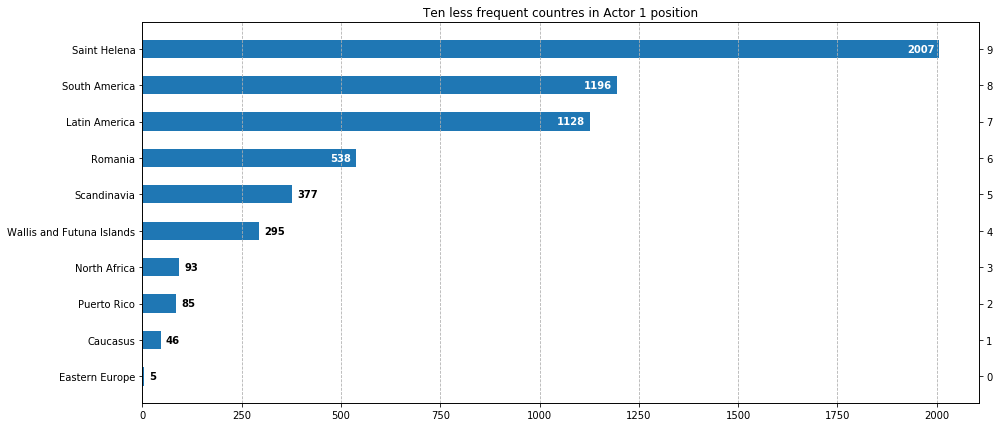

In [236]:
query = """
SELECT Actor1CountryCode, count(*) AS NumberOfParticipatingAsActor1
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT Actor1CountryCode IS NULL
GROUP BY Actor1CountryCode
ORDER BY NumberOfParticipatingAsActor1"""
#df = get_result_dataframe(query)
rank_chart(df[-10:]['NumberOfParticipatingAsActor1'],
           df[-10:]['Actor1CountryCode'].map(country_code_to_name_mapping),
           'Ten most frequent countres in Actor 1 position')
rank_chart(df[:10]['NumberOfParticipatingAsActor1'],
           df[:10]['Actor1CountryCode'].map(country_code_to_name_mapping),
           'Ten less frequent countres in Actor 1 position')

9


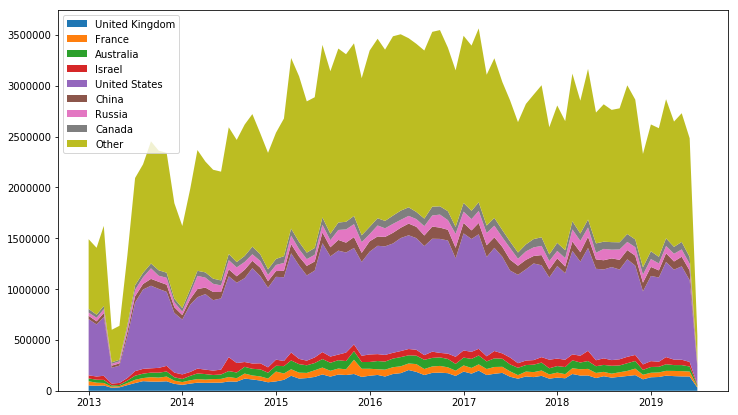

In [314]:
query = """
SELECT MonthYear, Actor1CountryCode, count(*) AS NumberOfParticipatingAsActor1
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT Actor1CountryCode IS NULL
GROUP BY MonthYear, Actor1CountryCode"""
#df = get_result_dataframe(query)
df = pd.read_csv('bq-results-20190709-083256-ch06j8ocji3y.csv')
cat_month_year_stack_plot(df, 
                          'Actor1CountryCode', 
                          'NumberOfParticipatingAsActor1', 
                          country_code_to_name_mapping,
                         4)

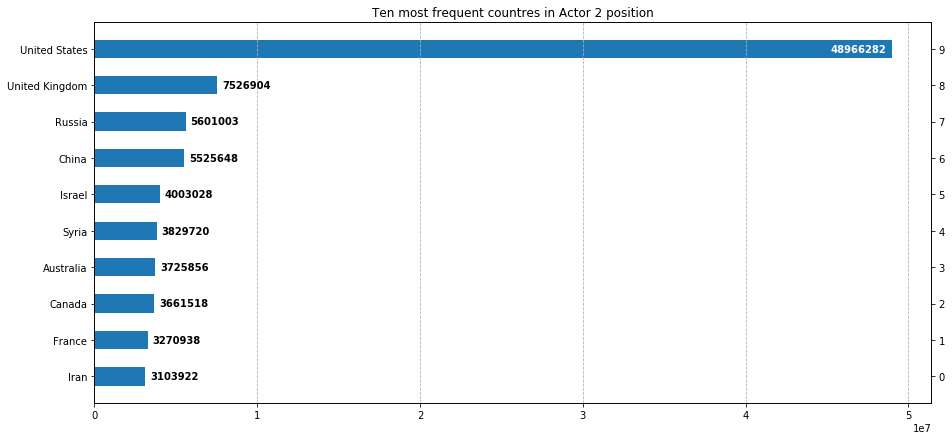

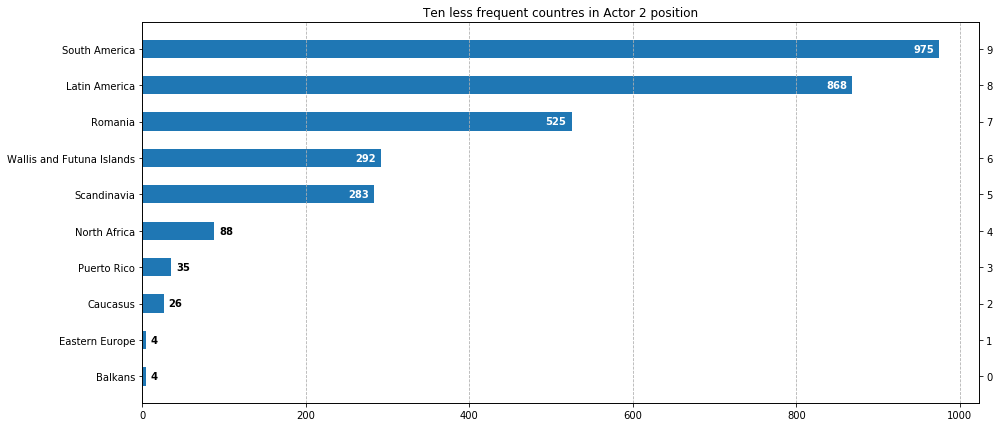

In [237]:
query = """
SELECT Actor2CountryCode, count(*) AS NumberOfParticipatingAsActor2
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT Actor2CountryCode IS NULL
GROUP BY Actor2CountryCode
ORDER BY NumberOfParticipatingAsActor2"""
df = get_result_dataframe(query)
rank_chart(df[-10:]['NumberOfParticipatingAsActor2'],
           df[-10:]['Actor2CountryCode'].map(country_code_to_name_mapping),
           'Ten most frequent countres in Actor 2 position')
rank_chart(df[:10]['NumberOfParticipatingAsActor2'],
           df[:10]['Actor2CountryCode'].map(country_code_to_name_mapping),
           'Ten less frequent countres in Actor 2 position')

12


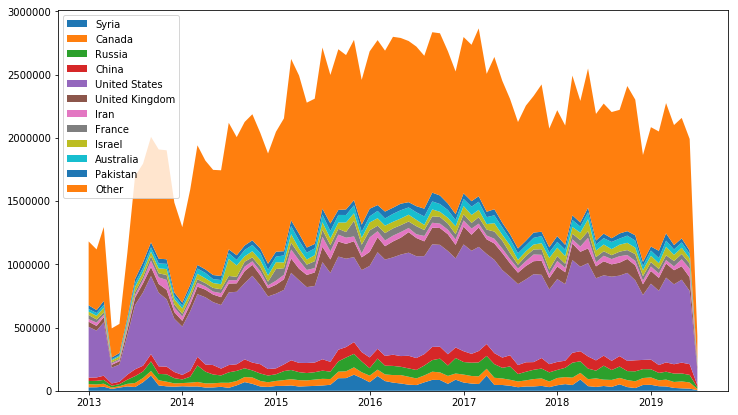

In [315]:
query = """
SELECT MonthYear, Actor2CountryCode, count(*) AS NumberOfParticipatingAsActor2
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT Actor2CountryCode IS NULL
GROUP BY MonthYear, Actor2CountryCode"""
#df = get_result_dataframe(query)
df = pd.read_csv('bq-results-20190709-083525-xjqxnb8802l4.csv')
cat_month_year_stack_plot(df, 
                          'Actor2CountryCode', 
                          'NumberOfParticipatingAsActor2', 
                          country_code_to_name_mapping,
                         4)

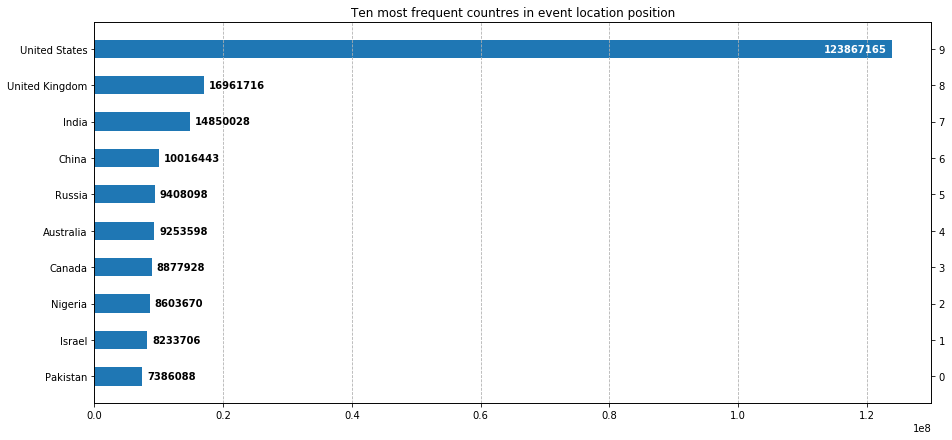

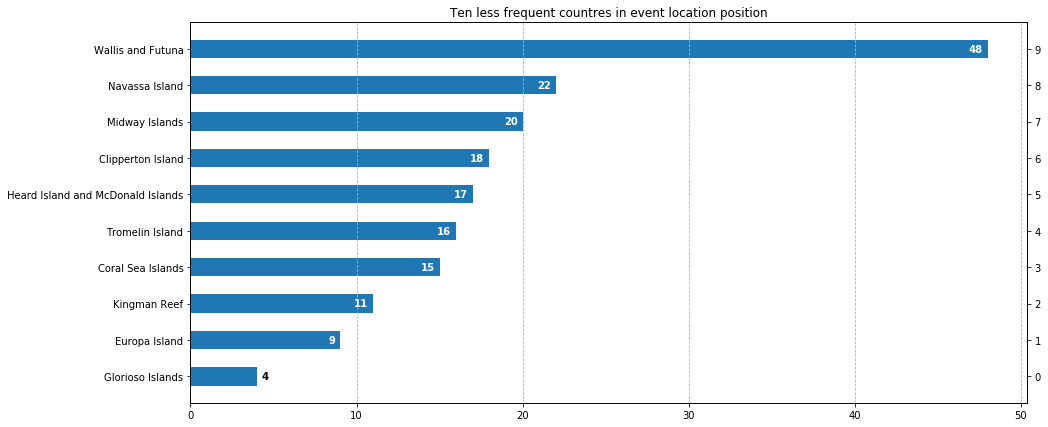

In [257]:
query = """
SELECT ActionGeo_CountryCode, count(*) AS NumberOfParticipatingAsEventLoc
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT ActionGeo_CountryCode IS NULL
GROUP BY ActionGeo_CountryCode
ORDER BY NumberOfParticipatingAsEventLoc"""
df = get_result_dataframe(query)
rank_chart(df[-10:]['NumberOfParticipatingAsEventLoc'],
           df[-10:]['ActionGeo_CountryCode'].map(fpis_country_code_to_name_mapping),
           'Ten most frequent countres in event location position')
rank_chart(df[:10]['NumberOfParticipatingAsEventLoc'],
           df[:10]['ActionGeo_CountryCode'].map(fpis_country_code_to_name_mapping),
           'Ten less frequent countres in event location position')

13


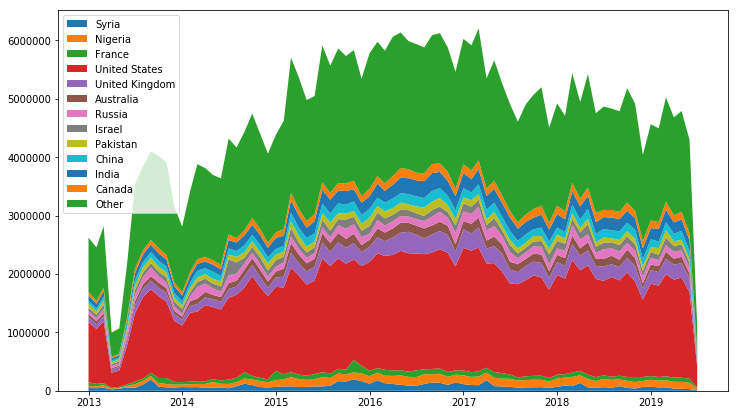

In [317]:
query = """
SELECT MonthYear, ActionGeo_CountryCode, count(*) AS NumberOfParticipatingAsEventLoc
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT ActionGeo_CountryCode  IS NULL
GROUP BY MonthYear, ActionGeo_CountryCode"""
#df = get_result_dataframe(query)
df = pd.read_csv('bq-results-20190709-090421-jzlfqa8j39n1.csv')
cat_month_year_stack_plot(df, 
                          'ActionGeo_CountryCode', 
                          'NumberOfParticipatingAsEventLoc', 
                          fpis_country_code_to_name_mapping,
                         4)

In [258]:
query = """
SELECT CORR(NumSources, NumArticles) AS SourcesArticlesCorr,
CORR(NumSources, NumMentions) AS SourcesMentionsCorr,
CORR(NumMentions, NumArticles) AS MentionsArticlesCorr
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301"""
df = get_result_dataframe(query)
df

MentionsArticlesCorr  SourcesArticlesCorr  SourcesMentionsCorr
0              0.990015             0.773193             0.761974

In [284]:
query = """
SELECT EventBaseCode, count(*) AS CategoryCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
GROUP BY EventBaseCode"""
df = get_result_dataframe(query)
df['EventType'] = df['EventBaseCode'].apply(lambda type_id: type_id[:2])
category_sum = df.groupby('EventType')['CategoryCount'].sum().sample(frac=1)
category_sum.index = pd.Series(category_sum.index).map(event_codes['EVENTDESCRIPTION'])
threshold = category_sum.sum() * 0.02
category_sum['OTHER'] = category_sum.loc[category_sum < threshold].sum()
category_sum = category_sum.loc[category_sum > threshold]

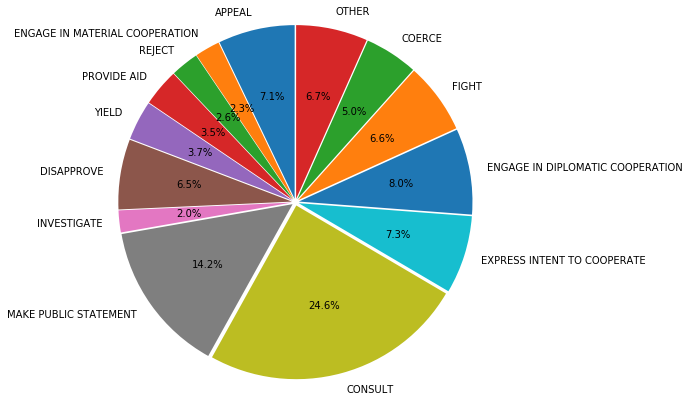

In [288]:
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(category_sum, 
        explode=[0.02]*category_sum.shape[0], 
        labels=category_sum.index,
        autopct='%1.1f%%', 
        startangle=90)
ax1.axis('equal') 
ax1.set_title('')
plt.show()

In [12]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
country_names = []
shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',
                                            category='cultural', name=shapename)
for country in shpreader.Reader(countries_shp).records():
    country_names.append(country.attributes['NAME'])

In [13]:
fpis_country_codes['map_name'] = fpis_country_codes['country_name'].apply(
    lambda c_name: c_name if c_name in country_names else np.NaN)

In [14]:
fpis_country_codes.loc[17].map_name = u'Bahamas'
fpis_country_codes.loc[30].map_name = u'Bosnia and Herz.'
fpis_country_codes.loc[45].map_name = u'Central African Rep.'
fpis_country_codes.loc[48].map_name = u'China'
fpis_country_codes.loc[54].map_name = u'Dem. Rep. Congo'
fpis_country_codes.loc[58].map_name = u'Côte d\'Ivoire'
fpis_country_codes.loc[62].map_name = u'Czechia'
fpis_country_codes.loc[63].map_name = u'Slovakia'
fpis_country_codes.loc[68].map_name = u'Dominican Rep.'
fpis_country_codes.loc[75].map_name = u'Eq. Guinea'
fpis_country_codes.loc[81].map_name = u'Falkland Is.'
fpis_country_codes.loc[88].map_name = u'Fr. S. Antarctic Lands'
fpis_country_codes.loc[90].map_name = u'Gambia'
fpis_country_codes.loc[104].map_name = u'Guinea'
fpis_country_codes.loc[146].map_name = u'Macedonia'
fpis_country_codes.loc[223].map_name = u'Solomon Is.'
fpis_country_codes.loc[228].map_name = u'S. Sudan'
fpis_country_codes.loc[259].map_name = u'United States of America'
fpis_country_codes.loc[265].map_name = u'Vietnam'
fpis_country_codes.loc[270].map_name = u'W. Sahara'

In [15]:
cameo_county_codes = pd.read_csv('cameo_cauntry_codes.csv', index_col=0)

In [16]:
def map_category_plot(country_id_to_cat_mapping, cat_id_to_name_mapping, code_type='fips'):
    cmap = matplotlib.cm.get_cmap('Paired')
    cat_color = {cat_id: cmap(i) for i, cat_id in enumerate(country_id_to_cat_mapping.unique())}
    
    if code_type == 'cameo':
        country_map_name_to_id_mapping = cameo_county_codes.groupby('map_name')['CODE'].first()
    elif code_type == 'fips':
        country_map_name_to_id_mapping = fpis_country_codes.groupby('map_name')['country_code'].first()
    else:
        raise(Exception('unknown coutry code'))
        
    plt.figure(figsize(18, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for country in shpreader.Reader(countries_shp).records():
        try:
            country_id = country_map_name_to_id_mapping.loc[country.attributes['NAME']]
            cat_id = country_id_to_cat_mapping.loc[country_id]
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=cat_color[cat_id][:-1],
                              label=cat_id)
        except KeyError as e:
            pass

    legend_elements = [Line2D([0], [0], color=cat_color[cat_id], lw=4, 
                              label=cat_id_to_name_mapping.loc[cat_id]) 
                       for cat_id in country_id_to_cat_mapping.unique()]   
    plt.legend(handles=legend_elements, 
               bbox_to_anchor=(0.5, -0.23), 
               ncol=3, 
               loc='lower center')

    plt.show()

In [36]:
fips_iso_mapping = pd.read_csv('fips-iso-country.csv', index_col='FIPS')['ISO']

In [47]:
parameters = {
    'range': ("201301", "201905"),
    'country_id': 'PL',
    'actor_type': 1,
}

query = """
SELECT MonthYear AS MonthYear, Actor{4}Geo_CountryCode AS Country, COUNT(*) AS EventCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= {0}
AND MonthYear < {1}
AND Actor{3}Geo_CountryCode = "{2}"
AND Actor{4}Geo_CountryCode IS NOT NULL
GROUP BY MonthYear, Actor{4}Geo_CountryCode
ORDER BY MonthYear, Actor{4}Geo_CountryCode
""".format(
    parameters['range'][0],
    parameters['range'][1],
    parameters['country_id'],
    parameters['actor_type'],
    3 - parameters['actor_type']
)
df = get_result_dataframe(query)

In [58]:
df = backup_df.copy()

In [59]:
import plotly_express as px
from itertools import product
df['country_iso'] = df['Country'].map(fips_iso_mapping)
df.dropna(inplace=True)
df['EventCountLog'] = np.log10(df['EventCount'])
df['MonthYear'] = df['MonthYear'].apply(
                    lambda date: str(int(date / 100)) + "-" + str(int(date % 100)))

columns = ['country_iso','MonthYear']

In [54]:
filler = pd.DataFrame(list(product(df['country_iso'].unique(), df['MonthYear'].unique())), 
                      columns=columns)

In [66]:
filled = df.join(filler.groupby(columns).count(), on=columns, how='right')[columns + ['EventCountLog']]
filled['EventCountLog'].fillna(0.0, inplace=True)

In [67]:
px.choropleth(
    filled, 
    locations='country_iso', 
    locationmode='ISO-3', 
    color='EventCountLog', 
    animation_frame='MonthYear',
    color_continuous_scale=px.colors.sequential.Aggrnyl)

In [191]:
query = """
SELECT Actor2Geo_CountryCode, EventBaseCode, count(*) AS Count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor1Geo_CountryCode = "PL"
GROUP BY Actor2Geo_CountryCode, EventBaseCode"""
#df = get_result_dataframe(query)
df['EventBaseCode'] = df['EventBaseCode'].apply(lambda val: val[:2])
df = df.groupby(['Actor2Geo_CountryCode', 'EventBaseCode'])['Count'].sum()
df = df[df.groupby(level='Actor2Geo_CountryCode').transform(max) == df]
cat_df = pd.Series(df.index.get_level_values('EventBaseCode'))
cat_df.index = df.index
country_id_to_cat_mapping = pd.concat([df,cat_df], axis=1
                                     ).groupby(level='Actor2Geo_CountryCode')['EventBaseCode'].first()

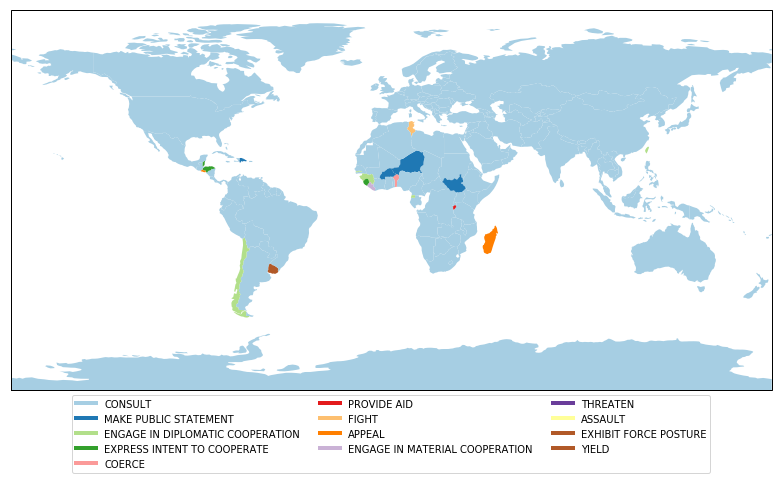

In [235]:
map_category_plot(country_id_to_cat_mapping, event_codes['EVENTDESCRIPTION'])

In [237]:
query = """
SELECT Actor1Geo_CountryCode, EventBaseCode, count(*) AS Count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
AND Actor2Geo_CountryCode = "PL"
GROUP BY Actor1Geo_CountryCode, EventBaseCode"""
df = get_result_dataframe(query)
df['EventBaseCode'] = df['EventBaseCode'].apply(lambda val: val[:2])
df = df.groupby(['Actor1Geo_CountryCode', 'EventBaseCode'])['Count'].sum()
df = df[df.groupby(level='Actor1Geo_CountryCode').transform(max) == df]
cat_df = pd.Series(df.index.get_level_values('EventBaseCode'))
cat_df.index = df.index
country_id_to_cat_mapping = pd.concat([df,cat_df], axis=1
                                     ).groupby(level='Actor1Geo_CountryCode')['EventBaseCode'].first()

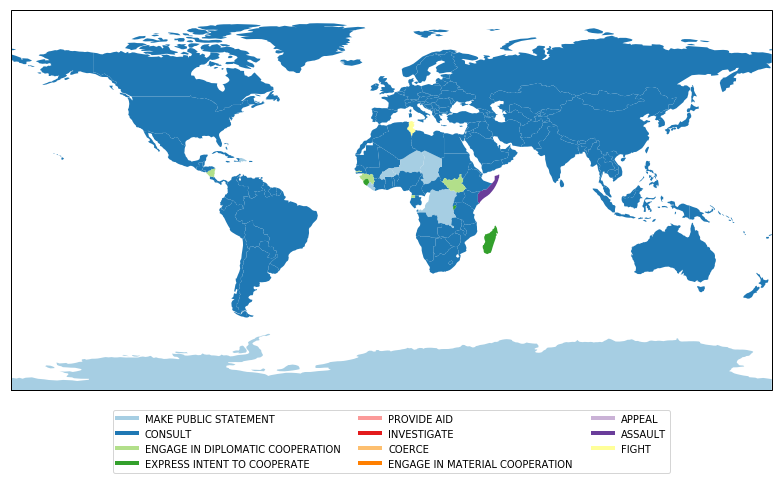

In [238]:
map_category_plot(country_id_to_cat_mapping, event_codes['EVENTDESCRIPTION'])

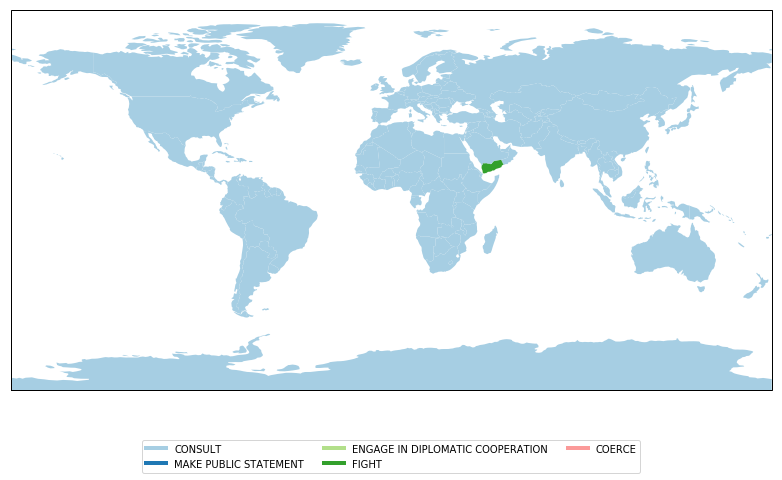

In [44]:
query = """
SELECT Actor1Geo_CountryCode, EventBaseCode, count(*) AS Count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
GROUP BY Actor1Geo_CountryCode, EventBaseCode"""
df = get_result_dataframe(query)
df['EventBaseCode'] = df['EventBaseCode'].apply(lambda val: val[:2])
df = df.groupby(['Actor1Geo_CountryCode', 'EventBaseCode'])['Count'].sum()
df = df[df.groupby(level='Actor1Geo_CountryCode').transform(max) == df]
cat_df = pd.Series(df.index.get_level_values('EventBaseCode'))
cat_df.index = df.index
country_id_to_cat_mapping = pd.concat([df,cat_df], axis=1
                                     ).groupby(level='Actor1Geo_CountryCode')['EventBaseCode'].first()
map_category_plot(country_id_to_cat_mapping, event_codes['EVENTDESCRIPTION'])

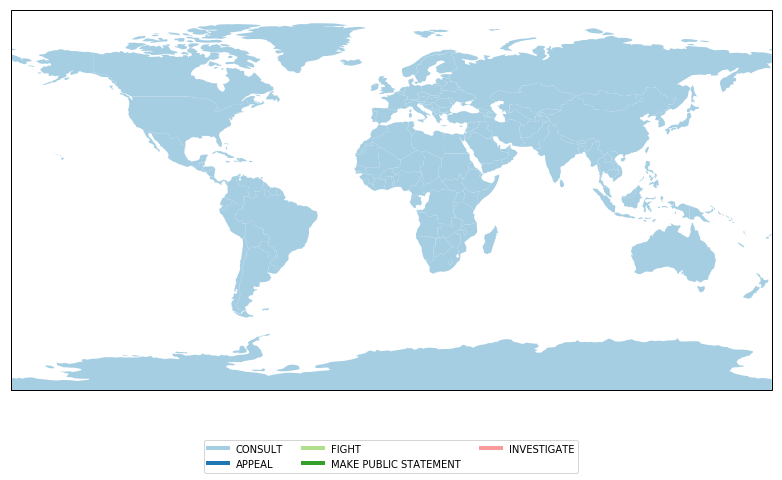

In [45]:
query = """
SELECT Actor2Geo_CountryCode, EventBaseCode, count(*) AS Count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
GROUP BY Actor2Geo_CountryCode, EventBaseCode"""
df = get_result_dataframe(query)
df['EventBaseCode'] = df['EventBaseCode'].apply(lambda val: val[:2])
df = df.groupby(['Actor2Geo_CountryCode', 'EventBaseCode'])['Count'].sum()
df = df[df.groupby(level='Actor2Geo_CountryCode').transform(max) == df]
cat_df = pd.Series(df.index.get_level_values('EventBaseCode'))
cat_df.index = df.index
country_id_to_cat_mapping = pd.concat([df,cat_df], axis=1
                                     ).groupby(level='Actor2Geo_CountryCode')['EventBaseCode'].first()
map_category_plot(country_id_to_cat_mapping, event_codes['EVENTDESCRIPTION'])

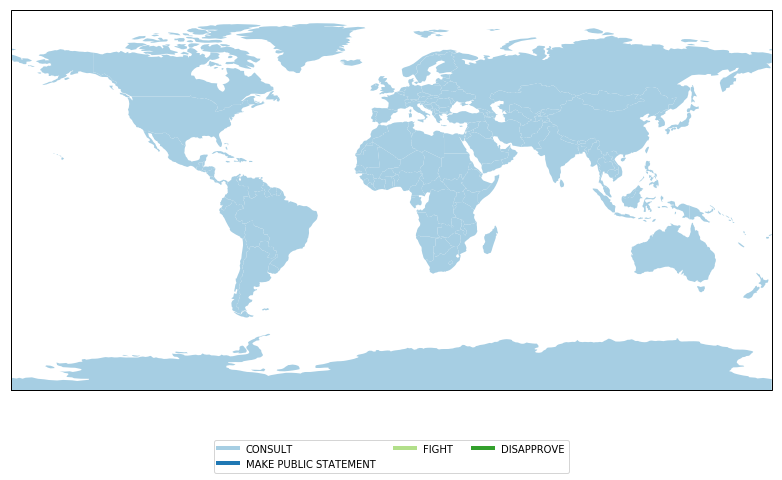

In [46]:
query = """
SELECT ActionGeo_CountryCode, EventBaseCode, count(*) AS Count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301
GROUP BY ActionGeo_CountryCode, EventBaseCode"""
df = get_result_dataframe(query)
df['EventBaseCode'] = df['EventBaseCode'].apply(lambda val: val[:2])
df = df.groupby(['ActionGeo_CountryCode', 'EventBaseCode'])['Count'].sum()
df = df[df.groupby(level='ActionGeo_CountryCode').transform(max) == df]
cat_df = pd.Series(df.index.get_level_values('EventBaseCode'))
cat_df.index = df.index
country_id_to_cat_mapping = pd.concat([df,cat_df], axis=1
                                     ).groupby(level='ActionGeo_CountryCode')['EventBaseCode'].last()
map_category_plot(country_id_to_cat_mapping, event_codes['EVENTDESCRIPTION'])

In [206]:
import matplotlib as mpl
def map_val_plot(country_id_to_val_mapping, code_type='fips', cmap=mpl.cm.Spectral, title=None):
    norm = mpl.colors.Normalize(vmin=country_id_to_val_mapping.min(), vmax=country_id_to_val_mapping.max())

    if code_type == 'cameo':
        country_map_name_to_id_mapping = cameo_county_codes.groupby('map_name')['CODE'].first()
    elif code_type == 'fips':
        country_map_name_to_id_mapping = fpis_country_codes.groupby('map_name')['country_code'].first()
    else:
        raise(Exception('unknown coutry code'))

    fig = plt.figure(figsize(18, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for country in shpreader.Reader(countries_shp).records():
        try:
            country_id = country_map_name_to_id_mapping.loc[country.attributes['NAME']]
            val = country_id_to_val_mapping.loc[country_id]
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=cmap(norm(val))[:-1])
        except KeyError as e:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                              facecolor=cmap(norm(0))[:-1])

    cax = fig.add_axes([0.30, 0.07, 0.40, 0.02])
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    ax2.set_xlim(-0.75, 1)
    if title:
        fig.suptitle(title)
    plt.show()

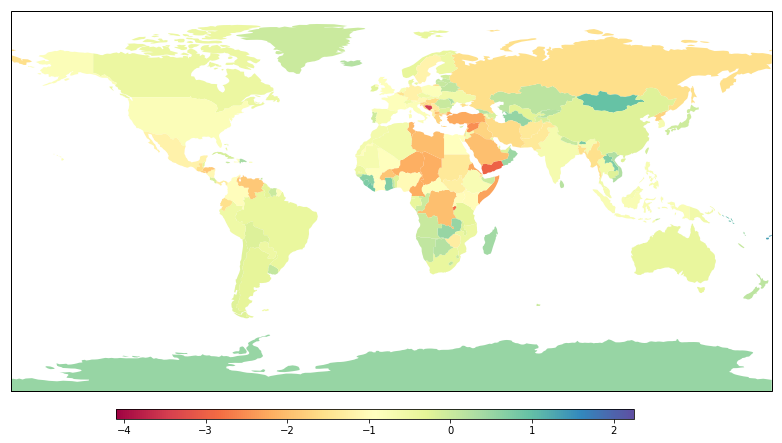

In [198]:
query = """
SELECT Actor1Geo_CountryCode, avg(AvgTone) as AvgTone
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT Actor1Geo_CountryCode IS NULL
AND NOT Actor2Geo_CountryCode = Actor1Geo_CountryCode
GROUP BY Actor1Geo_CountryCode"""
df = get_result_dataframe(query)
country_id_to_val_mapping = df.groupby('Actor1Geo_CountryCode')['AvgTone'].mean()
map_val_plot(country_id_to_val_mapping)

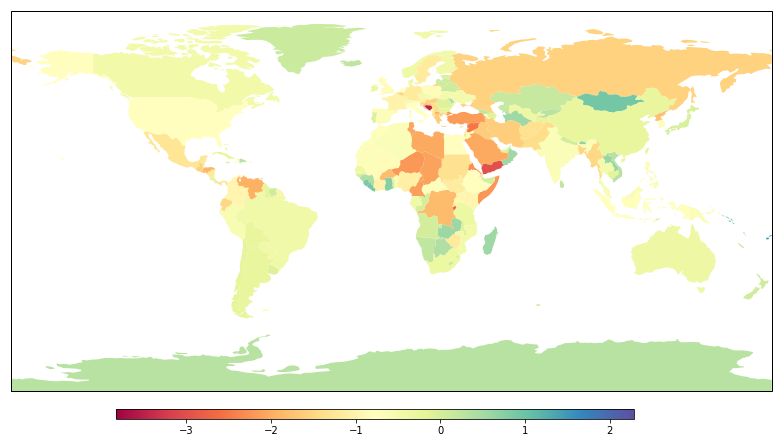

In [199]:
query = """
SELECT Actor2Geo_CountryCode, avg(AvgTone) as AvgTone
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT Actor2Geo_CountryCode IS NULL
AND NOT Actor2Geo_CountryCode = Actor1Geo_CountryCode
GROUP BY Actor2Geo_CountryCode"""
df = get_result_dataframe(query)
country_id_to_val_mapping = df.groupby('Actor2Geo_CountryCode')['AvgTone'].mean()
map_val_plot(country_id_to_val_mapping)

In [124]:
query = """
SELECT Actor1Geo_CountryCode, Actor2Geo_CountryCode, avg(AvgTone) as AvgTone
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND NOT Actor1Geo_CountryCode IS NULL
AND NOT Actor2Geo_CountryCode IS NULL
GROUP BY Actor1Geo_CountryCode, Actor2Geo_CountryCode
HAVING count(*) > 10"""
df = get_result_dataframe(query)

contries_with_max_tone = df[df.groupby(['Actor1Geo_CountryCode'])['AvgTone'].transform(max) == df['AvgTone']]
contries_with_max_tone = contries_with_max_tone.groupby('Actor1Geo_CountryCode').first()['Actor2Geo_CountryCode']

contries_with_min_tone = df[df.groupby(['Actor1Geo_CountryCode'])['AvgTone'].transform(min) == df['AvgTone']]
contries_with_min_tone = contries_with_min_tone.groupby('Actor1Geo_CountryCode').first()['Actor2Geo_CountryCode']

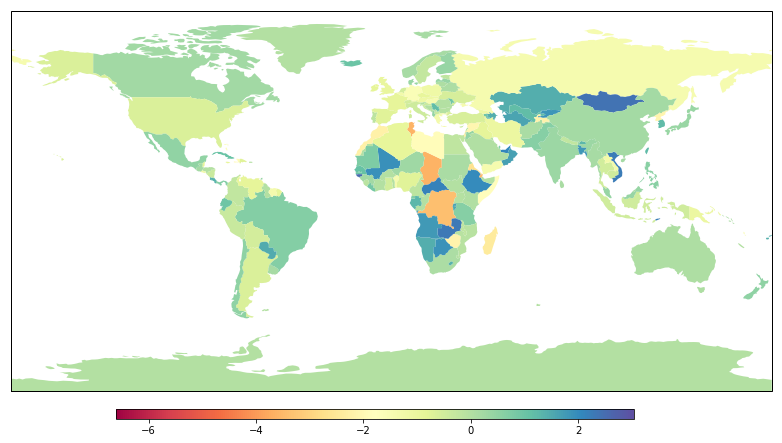

In [201]:
query = """
SELECT Actor2CountryCode, avg(AvgTone) as AvgTone
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor1CountryCode = "POL"
AND NOT Actor2CountryCode IS NULL
GROUP BY Actor2CountryCode
HAVING count(*) > 3"""
df = get_result_dataframe(query)
country_to_val_mapping = df.groupby('Actor2CountryCode')['AvgTone'].mean()
country_to_val_mapping = country_to_val_mapping.reindex(cameo_county_codes.CODE.unique())
country_to_val_mapping.fillna(0, inplace=True)
map_val_plot(df.groupby('Actor2CountryCode')['AvgTone'].mean(), code_type='cameo')

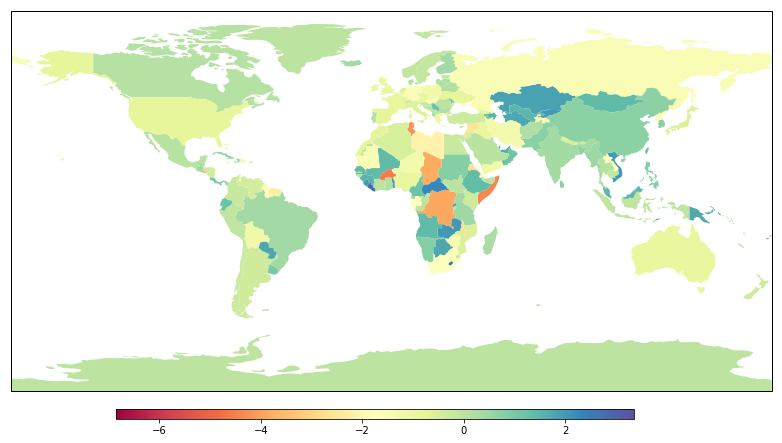

In [200]:
query = """
SELECT Actor1CountryCode, avg(AvgTone) as AvgTone
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor2CountryCode = "POL"
AND NOT Actor1CountryCode IS NULL
GROUP BY Actor1CountryCode
HAVING count(*) > 3"""
df = get_result_dataframe(query)
country_to_val_mapping = df.groupby('Actor1CountryCode')['AvgTone'].mean()
country_to_val_mapping = country_to_val_mapping.reindex(cameo_county_codes.CODE.unique())
country_to_val_mapping.fillna(0, inplace=True)
map_val_plot(df.groupby('Actor1CountryCode')['AvgTone'].mean(), code_type='cameo')

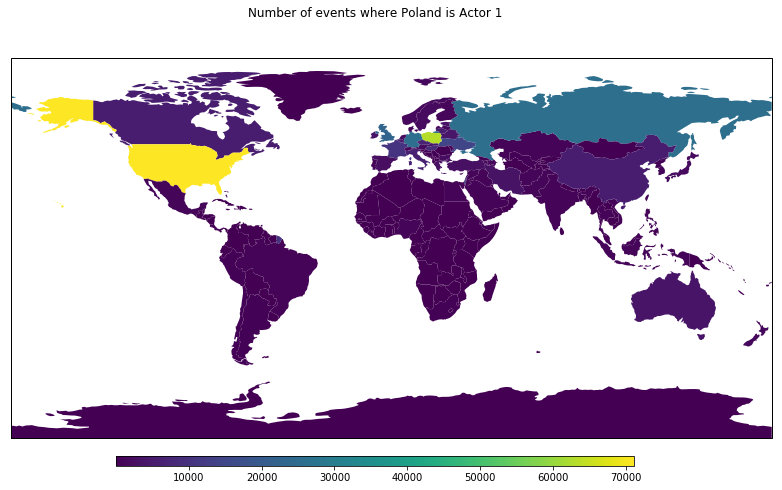

In [208]:
query = """
SELECT Actor1CountryCode, count(*) as Count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor2CountryCode = "POL"
AND NOT Actor1CountryCode IS NULL
GROUP BY Actor1CountryCode
HAVING count(*) > 3"""
df = get_result_dataframe(query)
country_to_val_mapping = df.groupby('Actor1CountryCode')['Count'].mean()
country_to_val_mapping = country_to_val_mapping.reindex(cameo_county_codes.CODE.unique())
country_to_val_mapping.fillna(0, inplace=True)
map_val_plot(df.groupby('Actor1CountryCode')['Count'].mean(), 
             code_type='cameo', 
             cmap=mpl.cm.viridis,
             title="Number of events where Poland is Actor 1")

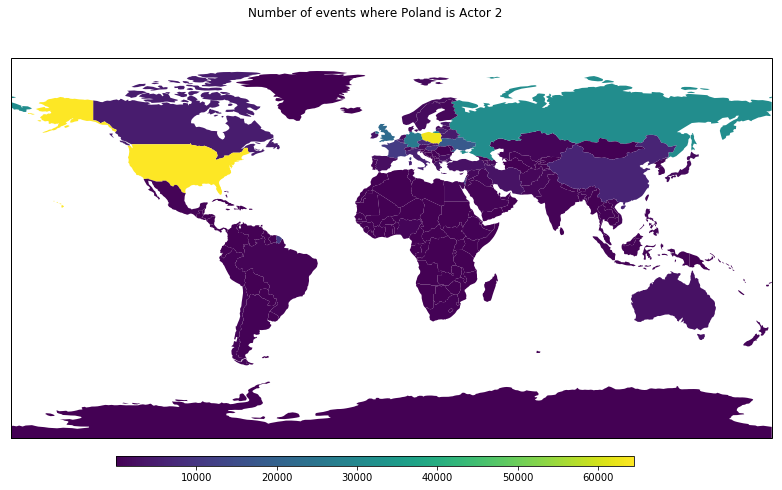

In [209]:
query = """
SELECT Actor2CountryCode, count(*) as Count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor1CountryCode = "POL"
AND NOT Actor2CountryCode IS NULL
GROUP BY Actor2CountryCode
HAVING count(*) > 3"""
df = get_result_dataframe(query)
country_to_val_mapping = df.groupby('Actor2CountryCode')['Count'].mean()
country_to_val_mapping = country_to_val_mapping.reindex(cameo_county_codes.CODE.unique())
country_to_val_mapping.fillna(0, inplace=True)
map_val_plot(df.groupby('Actor2CountryCode')['Count'].mean(), 
             code_type='cameo', 
             cmap=mpl.cm.viridis,
             title="Number of events where Poland is Actor 2")

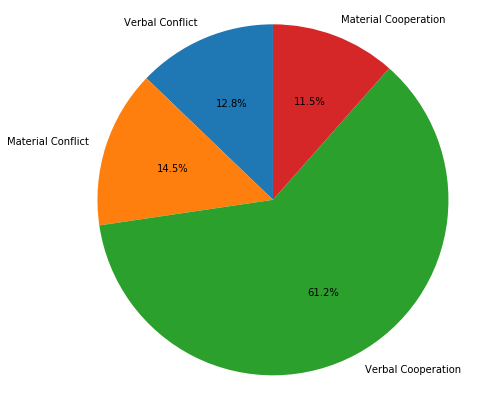

In [290]:
quad_class_dict = {1: 'Verbal Cooperation', 
                   2: 'Material Cooperation', 
                   3: 'Verbal Conflict',
                   4: 'Material Conflict'}
query = """
SELECT QuadClass, count(*) AS QuadClassCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
GROUP BY QuadClass"""
df = get_result_dataframe(query)
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(df['QuadClassCount'], 
        explode=[0]*4, 
        labels=df['QuadClass'].map(quad_class_dict),
        autopct='%1.1f%%', 
        startangle=90)
ax1.axis('equal') 
ax1.set_title('')
plt.show()

In [ ]:
cameo_country_id = 'POL'
fips_country_code = 'PL'

query = """
SELECT EventBaseCode as EventType, MonthYear AS Date, count(*) AS EventCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND (Actor2CountryCode  = "{}" 
OR Actor2Geo_CountryCode = "{}")
GROUP BY MonthYear, EventBaseCode""".format(
    cameo_country_id,
    fips_country_code)
df = get_result_dataframe(query)

In [20]:
query = """
SELECT Actor2Geo_CountryCode, count(*) AS CountryCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor1Geo_CountryCode="PL"
GROUP BY Actor2Geo_CountryCode"""
df = get_result_dataframe(query)
df.index = df['Actor2Geo_CountryCode'].map(fpis_country_code_to_name_mapping)
threshold = df['CountryCount'].sum() * 0.015
df.loc['OTHER'] = df.loc[df['CountryCount'] < threshold].sum()
df = df.loc[df['CountryCount'] >= threshold]
df.drop('Actor2Geo_CountryCode', axis=1, inplace=True)
df.rename({np.NaN: 'NONE'}, axis=0, inplace=True)

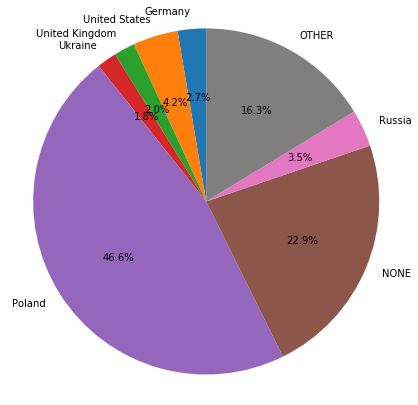

In [21]:
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(df['CountryCount'], 
        labels=df.index,
        autopct='%1.1f%%', 
        startangle=90)
ax1.axis('equal') 
ax1.set_title('')
plt.show()

7


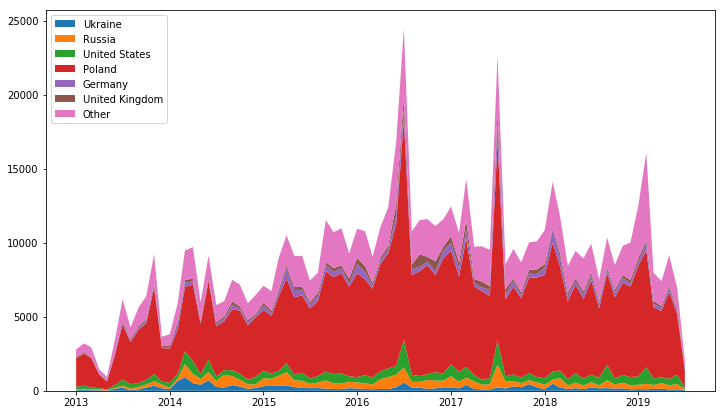

In [15]:
query = """
SELECT MonthYear, Actor2Geo_CountryCode, count(*) AS NumberOfParticipatingAsActor1
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor1Geo_CountryCode="PL"
GROUP BY MonthYear, Actor2Geo_CountryCode"""
df = get_result_dataframe(query)
cat_month_year_stack_plot(df, 
                          'Actor2Geo_CountryCode', 
                          'NumberOfParticipatingAsActor1', 
                          fpis_country_code_to_name_mapping,
                         4)

In [33]:
query = """
SELECT Actor1Geo_CountryCode, count(*) AS CountryCount
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor2Geo_CountryCode="PL"
GROUP BY Actor1Geo_CountryCode"""
df = get_result_dataframe(query)
df.index = df['Actor1Geo_CountryCode'].map(fpis_country_code_to_name_mapping)
threshold = df['CountryCount'].sum() * 0.015
df.loc['OTHER'] = df.loc[df['CountryCount'] < threshold].sum()
df = df.loc[df['CountryCount'] >= threshold]
df.drop('Actor1Geo_CountryCode', axis=1, inplace=True)
df.rename({np.NaN: 'NONE'}, axis=0, inplace=True)

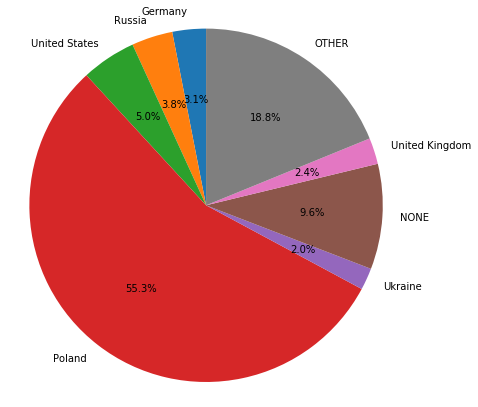

In [34]:
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(df['CountryCount'], 
        labels=df.index,
        autopct='%1.1f%%', 
        startangle=90)
ax1.axis('equal') 
ax1.set_title('')
plt.show()

7


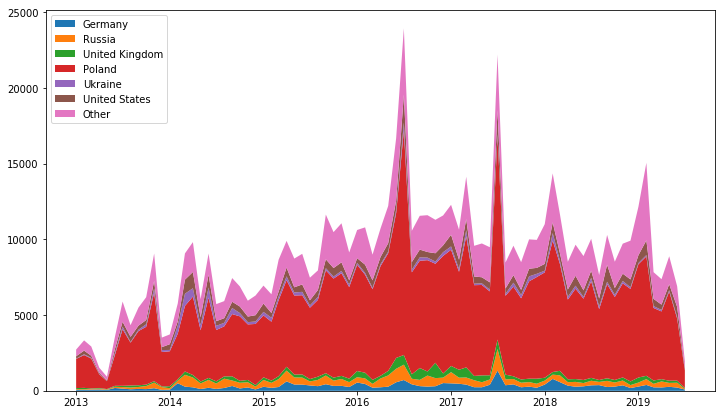

In [16]:
query = """
SELECT MonthYear, Actor1Geo_CountryCode, count(*) AS NumberOfParticipatingAsActor1
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 201301 
AND Actor2Geo_CountryCode="PL"
GROUP BY MonthYear, Actor1Geo_CountryCode"""
df = get_result_dataframe(query)
cat_month_year_stack_plot(df, 
                          'Actor1Geo_CountryCode', 
                          'NumberOfParticipatingAsActor1', 
                          fpis_country_code_to_name_mapping,
                         4)

In [358]:
query = """
SELECT Actor1CountryCode, Actor2CountryCode, SQLDATE as Date, count(*) AS DayCount
FROM `gdelt-bq.full.events`
WHERE MonthYear = 201906
AND NOT Actor1CountryCode IS NULL
AND NOT Actor2CountryCode IS NULL
GROUP BY Actor1CountryCode, Actor2CountryCode, SQLDATE
ORDER BY Actor1CountryCode, Actor2CountryCode, SQLDATE"""
#df = get_result_dataframe(query)
df = pd.read_csv('bq-results-20190710-104501-5btygg6i0e2x.csv')

In [356]:
from scipy.stats import pearsonr
import itertools


def get_country_corr(df, main_cat_val, main_cat, sec_cat, target_col, sec_cat2='Date'):
    unique_dates = list(sorted(df[sec_cat2].unique()))
    unique_countries = list(sorted(df[main_cat].unique()))
    multiindex = pd.MultiIndex.from_tuples(list(itertools.product(unique_countries, unique_dates)), 
                                           sortorder=None,
                                           names=[sec_cat2, main_cat])
    def get_corr(code1, code2):
        x1 = df[df[main_cat] == code1]
        x1 = x1.groupby([sec_cat, sec_cat2])[target_col].mean()
        x1 = x1.reindex(multiindex, fill_value=0.)
        x2 = df[df[main_cat] == code2]
        x2 = x2.groupby([sec_cat, sec_cat2])[target_col].mean()
        x2 = x2.reindex(multiindex, fill_value=0.)
        return(pearsonr(x1, x2))
    corr_vals = [(country_code, get_corr(main_cat_val, country_code)) for country_code in df[main_cat].unique()]
    return sorted(corr_vals, key=lambda val: -val[1][0])

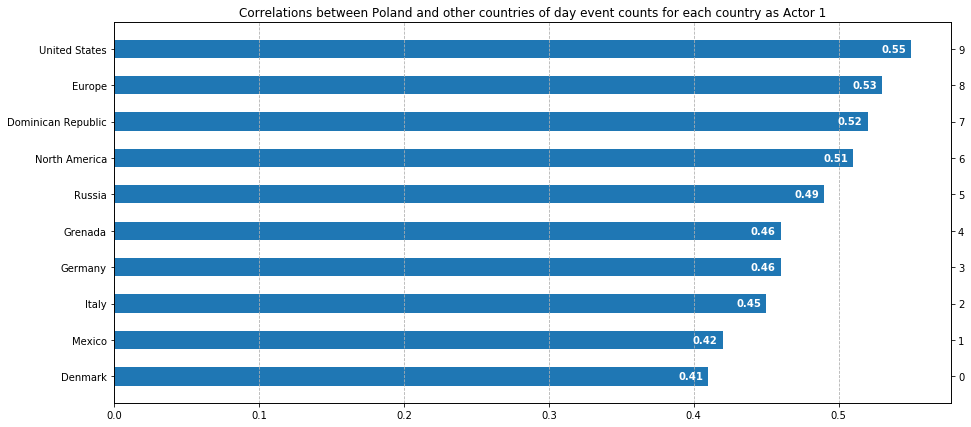

In [361]:
country_corr = get_country_corr(
    df,
    'POL',
    'Actor1CountryCode', 
    'Actor2CountryCode',
    'DayCount')
rank_chart(map(lambda val: round(val[1][0], 2), country_corr[1:11][::-1]),
           pd.Series(map(lambda val: val[0], country_corr[1:11][::-1])).map(country_code_to_name_mapping),
           'Correlations between Poland and other countries of day event counts for each country as Actor 1')

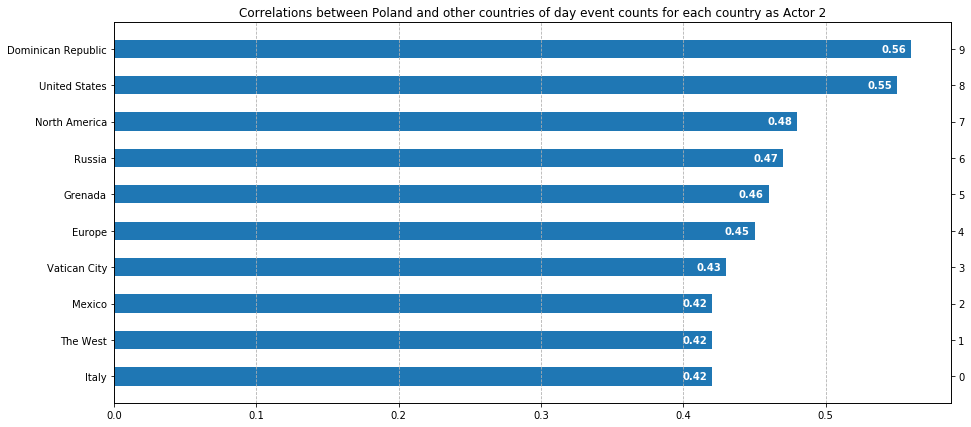

In [363]:
country_corr = get_country_corr(
    df,
    'POL',
    'Actor2CountryCode',
    'Actor1CountryCode', 
    'DayCount')
rank_chart(map(lambda val: round(val[1][0], 2), country_corr[1:11][::-1]),
           pd.Series(map(lambda val: val[0], country_corr[1:11][::-1])).map(country_code_to_name_mapping),
           'Correlations between Poland and other countries of day event counts for each country as Actor 2')

In [365]:
query = """
WITH 
  comb_unique AS 
  (SELECT u1.Actor1CountryCode, u2.Actor2CountryCode, u3.SQLDATE AS Date
    FROM 
        (SELECT DISTINCT Actor1CountryCode
         FROM `gdelt-bq.full.events`
         WHERE MonthYear = {}
         AND NOT Actor1CountryCode IS NULL
         ORDER BY Actor1CountryCode) AS u1
    CROSS JOIN
        (SELECT DISTINCT Actor2CountryCode
         FROM `gdelt-bq.full.events`
         WHERE MonthYear = {}
         AND NOT Actor2CountryCode IS NULL
         ORDER BY Actor2CountryCode) AS u2
    CROSS JOIN
        (SELECT DISTINCT SQLDATE
         FROM `gdelt-bq.full.events`
         WHERE MonthYear = {}
         ORDER BY SQLDATE) AS u3),
    filled_table AS 
    (SELECT comb_unique.Actor1CountryCode AS Actor1, 
            comb_unique.Actor2CountryCode AS Actor2, 
            comb_unique.Date AS Date,
            IFNULL(t1.AvgCount, 0.0) AS AvgCount
    FROM comb_unique
    LEFT JOIN
      (SELECT Actor1CountryCode, Actor2CountryCode, SQLDATE as Date, count(*) as AvgCount
      FROM `gdelt-bq.full.events`
      WHERE MonthYear = {}
      AND NOT Actor1CountryCode IS NULL
      AND NOT Actor2CountryCode IS NULL
      GROUP BY Actor1CountryCode, Actor2CountryCode, SQLDATE
      ORDER BY Actor1CountryCode, Actor2CountryCode, SQLDATE) AS t1
    ON comb_unique.Actor1CountryCode = t1.Actor1CountryCode
    AND comb_unique.Actor2CountryCode = t1.Actor2CountryCode
    AND comb_unique.Date = t1.Date)
SELECT t1.Actor1 AS Actor1, 
       t2.Actor1 AS Actor2,
       CORR(t1.AvgCount, t2.AvgCount) AS AvgCountCorr
FROM filled_table as t1
CROSS JOIN filled_table as t2
WHERE t1.Actor2 = t2.Actor2
AND t1.Date = t2.Date
AND t1.Actor1 < t2.Actor1
GROUP BY t1.Actor1, t2.Actor1
HAVING NOT IS_NAN(AvgCountCorr)
ORDER BY AvgCountCorr DESC
LIMIT 10""".format(*['201906'] * 4)
df = get_result_dataframe(query)

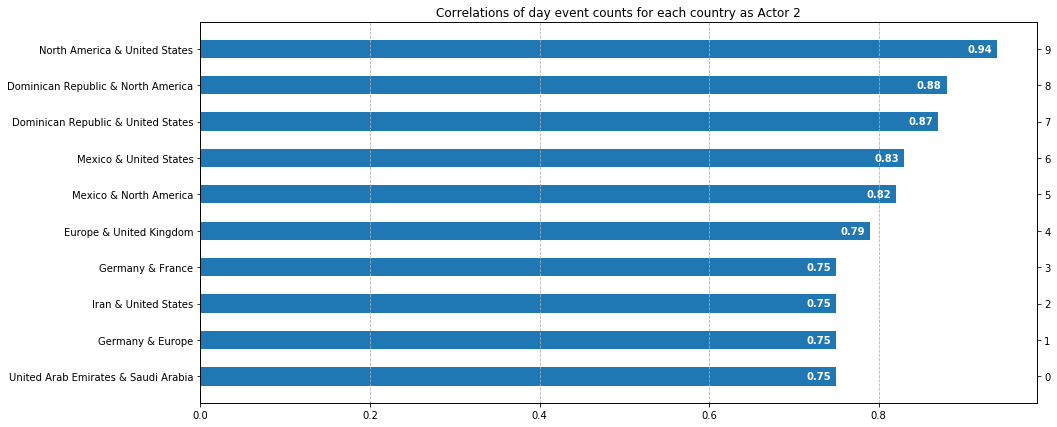

In [368]:
top_corr = df[::-1]
rank_chart(top_corr['AvgCountCorr'].apply(lambda val: round(val, 2)),
           map(lambda (c1, c2): c1 + ' & ' + c2, zip(top_corr.Actor1.map(country_code_to_name_mapping), 
               top_corr.Actor2.map(country_code_to_name_mapping))),
           'Correlations of day event counts for each country as Actor 2')

In [3]:
import pandas as pd

In [8]:
df = pd.read_csv('tmp.csv')

In [10]:
!head -n 1 FIPS.country.csv 

AF	Afghanistan


In [17]:
fips_id_to_name_mapping = pd.read_csv('FIPS.country.csv', sep='\t', names=['id','name'],index_col='id')['name']

In [18]:
df['Labels'] = df['Actor1'].map(fips_id_to_name_mapping) + ' & ' + df['Actor2'].map(fips_id_to_name_mapping)

In [19]:
df

Actor1 Actor2  AvgCountCorr                                         Labels
0     GZ     IS      0.682161                            Gaza Strip & Israel
1     IS     WE      0.628930                             Israel & West Bank
2     NR     PS      0.466031                                  Nauru & Palau
3     KN     VM      0.441288  North Korea & Vietnam, Democratic Republic of
4     GT     HO      0.435156                           Guatemala & Honduras
5     CH     PG      0.410908                        China & Spratly Islands
6     BK     RB      0.380238                                            NaN
7     GZ     WE      0.374599                         Gaza Strip & West Bank
8     ES     HO      0.372054                         El Salvador & Honduras
9     RW     UG      0.355870                                Rwanda & Uganda

In [342]:
query = """
SELECT Actor1CountryCode, Actor2CountryCode, SQLDATE as Date, avg(AvgTone) AS AvgTone
FROM `gdelt-bq.full.events`
WHERE MonthYear = 201906
AND NOT Actor1CountryCode IS NULL
AND NOT Actor2CountryCode IS NULL
GROUP BY Actor1CountryCode, Actor2CountryCode, SQLDATE
ORDER BY Actor1CountryCode, Actor2CountryCode, SQLDATE"""
df = get_result_dataframe(query)

In [ ]:
query = """
SELECT Actor1Name, Actor1CountryCode, Actor2Name, Actor2CountryCode, AvgTone 
FROM `gdelt-bq.full.events`
WHERE MonthYear = 201905 
AND NOT Actor1Name IS NULL
AND NOT Actor1CountryCode IS NULL
AND NOT Actor2Name IS NULL
AND NOT Actor2CountryCode IS NULL"""
graph = get_result_dataframe(query)

In [8]:
graph = pd.read_csv('graph.csv')

In [ ]:
graph['Actor1'] = graph['Actor1Name'] + ' ' + graph['Actor1CountryCode']
graph['Actor2'] = graph['Actor2Name'] + ' ' + graph['Actor2CountryCode']

In [ ]:
unique_actors = set(graph['Actor1'].unique()).union(set(graph['Actor2'].unique()))
actor_name_to_id_dict = {name: index for index, name in enumerate(unique_actors)} 

In [ ]:
graph['Actor1_id'] = graph['Actor1'].map(actor_name_to_id_dict)
graph['Actor2_id'] = graph['Actor2'].map(actor_name_to_id_dict)

In [ ]:
graph['weight'] = (graph['AvgTone'] - graph['AvgTone'].mean()) / graph['AvgTone'].std()
graph['weight'] = graph['weight'] - graph['weight'].min()

In [ ]:
desc = pd.DataFrame(actor_name_to_id_dict.items(), columns=['Name', 'Index'])

In [ ]:
graph[graph['Actor1'] != graph['Actor2']]

In [18]:
with open('p_graph.gdf', 'w') as dest:
    dest.write('nodedef>name INT,label VARCHAR\n')
    desc.to_csv(dest, 
                 columns=['Index', 'Name'], 
                 header=False,
                 index=False,
                 mode='a+')
    dest.write('edgedef>node1 INT,node2 INT, weight DOUBLE\n')
    graph.to_csv(dest, 
                 columns=['Actor1_id', 'Actor2_id', 'AvgTone'], 
                 header=False,
                 index=False,
                 mode='a+')

In [47]:
graph.to_csv('large_vis_input.txt', 
             columns=['Actor1_id', 'Actor2_id', 'AvgTone'], 
             header=False,
             index=False,
             sep=' ')

In [ ]:
!python LargeVis/LargeVis_run.py -input large_vis_input.txt -output large_vis_output.txt -fea 0 \
    -neigh 100

In [8]:
gf = pd.read_csv('large_vis_output.txt', sep=' ', names=['node_id', 'x', 'y'])

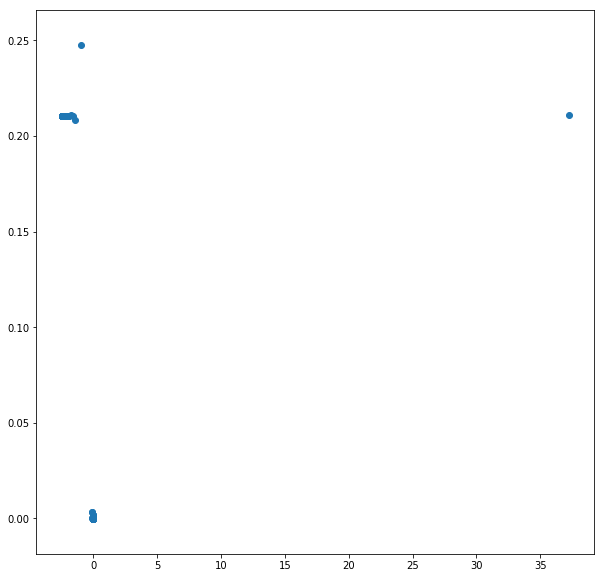

In [9]:
plt.figure(figsize(10, 10))
plt.scatter(gf.x, gf.y)
plt.show()

In [369]:
query = """
SELECT Actor1CountryCode, Actor2CountryCode, avg(AvgTone) as AvgTone
FROM `gdelt-bq.full.events`
WHERE MonthYear = 201905 
AND NOT Actor1CountryCode IS NULL
AND NOT Actor2CountryCode IS NULL
GROUP BY Actor1CountryCode, Actor2CountryCode"""
df = get_result_dataframe(query)

In [370]:
with open('p_graph.gdf', 'w') as dest:
    dest.write('nodedef>name VARCHAR,label VARCHAR\n')
    cameo_county_codes.to_csv(dest, 
                columns=['CODE', 'LABEL'], 
                header=False,
                index=False,
                mode='a+')
    dest.write('edgedef>node1 VARCHAR,node2 VARCHAR, weight DOUBLE\n')
    df.to_csv(dest, 
              columns=['Actor1CountryCode', 'Actor2CountryCode', 'AvgTone'], 
              header=False,
              index=False,
              mode='a+')

In [371]:
code_to_id_mapping = {code: index for index, code in enumerate(cameo_county_codes['CODE'])}
id_to_code_mapping = {index: code for index, code in enumerate(cameo_county_codes['CODE'])}

In [226]:
max_dist = df.AvgTone.max()

distance_matrix = np.full((len(code_to_id_mapping), len(code_to_id_mapping)), max_dist)

for index, row in df.iterrows():
    try:
        i = code_to_id_mapping[row['Actor1CountryCode']]
        j = code_to_id_mapping[row['Actor2CountryCode']]
        distance_matrix[i, j] = max_dist - row['AvgTone']
    except KeyError:
        pass

In [249]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=80, 
            learning_rate=600., 
            metric='precomputed')
transformed = tsne.fit_transform(distance_matrix)

In [256]:
from sklearn.manifold import MDS
mds = MDS(dissimilarity='precomputed')
sym_distance_matrix = (distance_matrix + distance_matrix.T) / 2
transformed = mds.fit_transform(sym_distance_matrix)

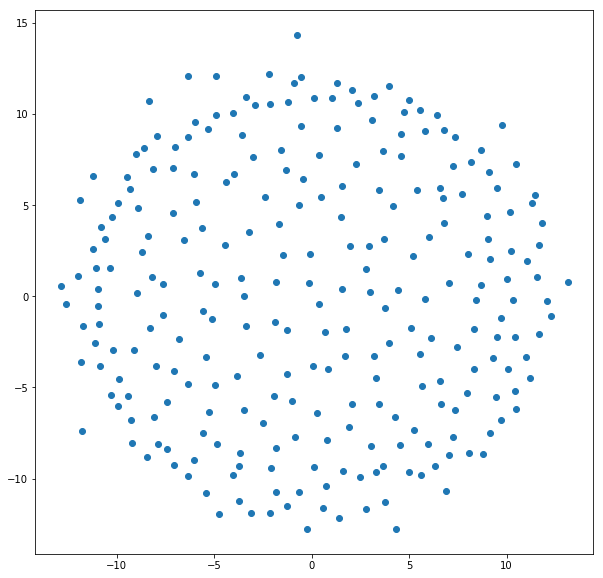

In [257]:
plt.figure(figsize(10, 10))
plt.scatter(transformed[:, 0], transformed[:, 1])
plt.show()

In [258]:
from sklearn.cluster import DBSCAN

In [265]:
dbscan = DBSCAN(eps=max_dist, metric='precomputed')
labels = dbscan.fit_predict(distance_matrix)

In [266]:
zip(cameo_county_codes['CODE'], labels)

[('WSB', -1),
 ('BAG', -1),
 ('GZS', -1),
 ('AFR', -1),
 ('ASA', -1),
 ('BLK', -1),
 ('CRB', -1),
 ('CAU', -1),
 ('CFR', -1),
 ('CAS', -1),
 ('CEU', -1),
 ('EIN', -1),
 ('EAF', -1),
 ('EEU', -1),
 ('EUR', -1),
 ('LAM', -1),
 ('MEA', -1),
 ('MDT', -1),
 ('NAF', -1),
 ('NMR', -1),
 ('PGS', -1),
 ('SCN', -1),
 ('SAM', -1),
 ('SAS', -1),
 ('SEA', -1),
 ('SAF', -1),
 ('WAF', -1),
 ('WST', -1),
 ('AFG', -1),
 ('ALA', -1),
 ('ALB', -1),
 ('DZA', -1),
 ('ASM', -1),
 ('AND', -1),
 ('AGO', -1),
 ('AIA', 0),
 ('ATG', -1),
 ('ARG', -1),
 ('ARM', -1),
 ('ABW', -1),
 ('AUS', -1),
 ('AUT', -1),
 ('AZE', 1),
 ('BHS', -1),
 ('BHR', 2),
 ('BGD', -1),
 ('BRB', -1),
 ('BLR', -1),
 ('BEL', -1),
 ('BLZ', -1),
 ('BEN', -1),
 ('BMU', -1),
 ('BTN', -1),
 ('BOL', -1),
 ('BIH', -1),
 ('BWA', -1),
 ('BRA', -1),
 ('VGB', -1),
 ('BRN', 1),
 ('BGR', -1),
 ('BFA', 3),
 ('BDI', 1),
 ('KHM', -1),
 ('CMR', -1),
 ('CAN', -1),
 ('CPV', -1),
 ('CYM', -1),
 ('CAF', -1),
 ('TCD', 2),
 ('CHL', -1),
 ('CHN', -1),
 ('COL', -1),